In [2]:
import datetime
import logging
import os
import numpy as np
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner,
)
import matplotlib.pyplot as plt
## Only when developing with VSCode in my repo 
#os.chdir('/home/nicolas/codeRepo/OceanPlatformControl') # here in Azure
os.chdir('/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl') # here in WSL
print(os.getcwd())
##
import pandas as pd
from ocean_navigation_simulator.utils.units import Distance
# These lines in VSCode to avoid reloading the kernel when changes are made to the external kernel
%load_ext autoreload
%autoreload 2

/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl


### Define Filenames

In [3]:
path_to_files = 'generated_media/metrics_csv_results/'
#file_containing_pb = 'problemsGOM.csv'
pb_name_hj_naive = 'problemsGOM_550_metrics_hj_naive.csv'
pb_name_reactive = 'problemsGOM_550_metrics_reactive.csv'
pb_name_flocking = 'problemsGOM_550_metrics_flocking.csv'

### Plot problem distribution

In [44]:
# TODO

### Extract metrics from csv files

In [78]:
metrics_hj_naive = pd.read_csv(f"{path_to_files}/{pb_name_hj_naive}")
metrics_hj_reactive = pd.read_csv(f"{path_to_files}/{pb_name_reactive}")
metrics_hj_flocking = pd.read_csv(f"{path_to_files}/{pb_name_flocking}")

In [79]:
metrics_hj_naive

,Unnamed: 0,Isolated_platform_metric,Number_of_collision,Reaching_target,Mean minimum distance to target among all platforms in deg,Mean maximum correction from optimal control degrees,Average Beta Index,Initial maximum degree of the graph,Final maximum degree of the graph,Mission_success
0,0,364600.0,0,1.0,0.0,0.0,0.450416,2,1,0
1,1,0.0,151,1.0,0.0,0.0,0.690361,1,3,0
2,2,0.0,0,1.0,0.0,0.0,1.359223,3,3,1
3,3,250400.0,0,1.0,0.0,0.0,0.890777,3,3,0
4,4,226800.0,0,1.0,0.0,0.0,0.750347,3,3,0
...,...,...,...,...,...,...,...,...,...,...
543,543,75800.0,0,1.0,0.0,0.0,0.938280,3,2,0
544,544,294200.0,0,1.0,0.0,0.0,0.856796,3,2,0
545,545,442600.0,0,1.0,0.0,0.0,0.684813,2,2,0
546,546,117200.0,590,1.0,0.0,0.0,1.144244,3,3,0


+ Get Non Feasible Missions 

In [80]:
non_feas_idx = metrics_hj_naive.index[metrics_hj_naive["Reaching_target"] < 1]
print("Number of infeasible missions: ", len(non_feas_idx), f"corresponds to {len(non_feas_idx)/len(metrics_hj_naive)*100} %")


Number of infeasible missions:  43 corresponds to 7.846715328467154 %


In [81]:
metrics_hj_naive.drop(non_feas_idx, axis=0, inplace=True)
metrics_hj_reactive.drop(non_feas_idx, axis=0, inplace=True)
metrics_hj_flocking.drop(non_feas_idx, axis=0, inplace=True)

In [62]:
len(non_feas)

43

In [42]:
import plotly.express as px
import plotly.graph_objects as go

+ Beta Index

In [32]:
beta_index_avg_dic = {"hj_naive": metrics_hj_naive["Average Beta Index"],
                      "hj_reactive": metrics_hj_reactive["Average Beta Index"],
                      "flocking": metrics_hj_flocking["Average Beta Index"]}
beta_index_avg_df = pd.DataFrame(beta_index_avg_dic)
fig = px.box(beta_index_avg_df)
# Add custom x and y labels
fig.update_layout(
    xaxis_title="controllers",
    yaxis_title="Average Beta Index over Missions"
)
fig.show()

+ Mean minimum distance to target among all platforms in deg

In [83]:
mean_min_dist_dict = {"hj_naive": Distance(deg=metrics_hj_naive["Mean minimum distance to target among all platforms in deg"]).km,
                      "hj_reactive": Distance(deg=metrics_hj_reactive["Mean minimum distance to target among all platforms in deg"]).km,
                      "flocking":Distance(deg=metrics_hj_flocking["Mean minimum distance to target among all platforms in deg"]).km}
idx_list = []
mean_min_dist_df = pd.DataFrame(mean_min_dist_dict)
fig = px.box(mean_min_dist_df, log_y=True)
# Add custom x and y labels
fig.update_layout(
    xaxis_title="controllers",
    yaxis_title="Mean minimum distance to target among all platforms in [km]"
)
fig.show()

### Get Metrics summary as a dict:

In [9]:
def get_metrics_summary(metrics_file:pd.DataFrame)->dict:
    return {
    "avg_beta_index":metrics_file["Average Beta Index"].mean(),
    "avg_isolated_pltf_integral_hj_naive": metrics_file["Isolated_platform_metric"].mean(),
    "avg_correction_from_opt_ctrl_deg": metrics_file["Mean maximum correction from optimal control degrees"].mean(),
    "avg_mean_min_dist_to_target_km": Distance(deg=metrics_file["Mean minimum distance to target among all platforms in deg"].mean()).km,
    "avg_nb_platfroms_reaching_target": metrics_file["Reaching_target"].mean(),
    "nb_missions_with_isolated_pltf": np.sum(metrics_file["Isolated_platform_metric"] > 0),
    "nb_missions_with_collisions": np.sum(metrics_file["Number_of_collision"] > 0),
    "nb_missions_success": np.sum(metrics_file["Mission_success"]==1),
}

  + HJ Multi-Agent Naive

In [10]:
metrics_summary_hj_naive = get_metrics_summary(metrics_hj_naive)
print(metrics_summary_hj_naive)

{'avg_beta_index': 1.0880202375046821, 'avg_isolated_pltf_integral_hj_naive': 140628.46715328467, 'avg_correction_from_opt_ctrl_deg': 0.0, 'avg_mean_min_dist_to_target_km': 0.5073981506901872, 'avg_nb_platfroms_reaching_target': 0.9657846715328468, 'nb_missions_with_isolated_pltf': 261, 'nb_missions_with_collisions': 218, 'nb_missions_success': 125}


+ HJ Multi-Agent Decentralized Reactive Control

In [11]:
metrics_summary_hj_reactive = get_metrics_summary(metrics_hj_reactive)
print(metrics_summary_hj_reactive)

{'avg_beta_index': 1.2192110794727005, 'avg_isolated_pltf_integral_hj_naive': 47844.24131627056, 'avg_correction_from_opt_ctrl_deg': 25.733680390652573, 'avg_mean_min_dist_to_target_km': 0.6600851125400857, 'avg_nb_platfroms_reaching_target': 0.9209323583180987, 'nb_missions_with_isolated_pltf': 157, 'nb_missions_with_collisions': 7, 'nb_missions_success': 337}


+ HJ Multi-Agent Flocking

In [12]:
metrics_summary_hj_flocking = get_metrics_summary(metrics_hj_flocking)
print(metrics_summary_hj_flocking)

{'avg_beta_index': 1.4106171221289112, 'avg_isolated_pltf_integral_hj_naive': 3908.4249084249086, 'avg_correction_from_opt_ctrl_deg': 24.368127967728753, 'avg_mean_min_dist_to_target_km': 0.5854424673870228, 'avg_nb_platfroms_reaching_target': 0.9409340659340659, 'nb_missions_with_isolated_pltf': 51, 'nb_missions_with_collisions': 7, 'nb_missions_success': 433}


### Plots

In [13]:
def plot_confusion_matrix(x, y, x_label, y_label, title_name:str):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    confusion_matrix = pd.crosstab(x, y, rownames=[x_label], colnames=[y_label])

    ax = sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.RdYlGn, square=True, fmt='g')
    # ax = sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.RdYlGn, square=True, norm=LogNorm(), fmt='g') # if heat map is in norm
    plt.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=True, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.plot
    plt.title(title_name)
    plt.show()

###  HJ naive vs Decentralized Reactive Control

+  Missions success counts

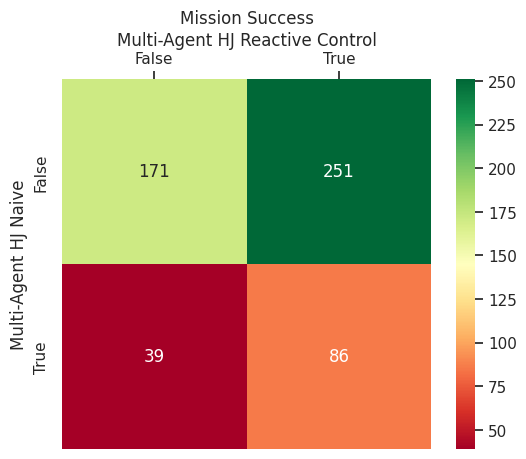

In [15]:
plot_confusion_matrix(metrics_hj_naive["Mission_success"]==1, 
                        metrics_hj_reactive["Mission_success"]==1, 'Multi-Agent HJ Naive', 
                        'Multi-Agent HJ Reactive Control', title_name="Mission Success")

+ Connectivity and Collision maintenance performance

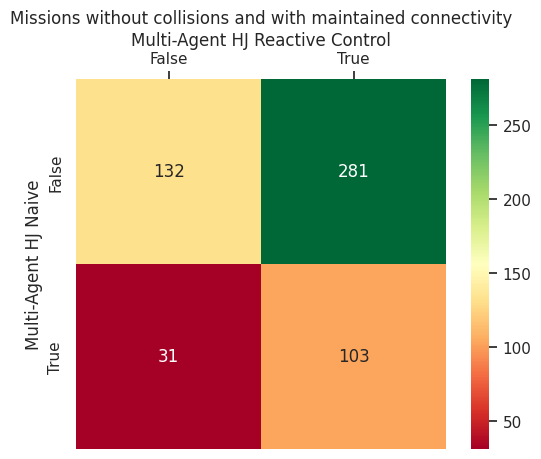

In [16]:
connect_objective_reactive = (metrics_hj_reactive["Isolated_platform_metric"]==0) & (metrics_hj_reactive["Number_of_collision"] == 0)
connect_objective_hj_naive = (metrics_hj_naive["Isolated_platform_metric"]==0) & (metrics_hj_naive["Number_of_collision"] == 0)
plot_confusion_matrix(connect_objective_hj_naive , connect_objective_reactive , 
    'Multi-Agent HJ Naive', 'Multi-Agent HJ Reactive Control', title_name= 'Missions without collisions and with maintained connectivity')

###  HJ naive vs Flocking

+  Missions success counts

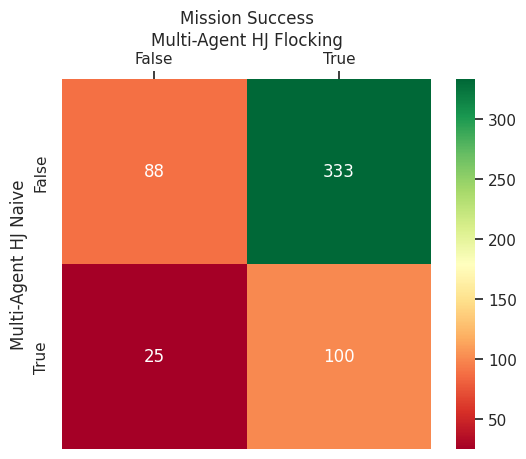

In [18]:
plot_confusion_matrix(metrics_hj_naive["Mission_success"]==1, 
                        metrics_hj_flocking["Mission_success"]==1, 'Multi-Agent HJ Naive', 
                        'Multi-Agent HJ Flocking', title_name="Mission Success")

+ Connectivity and Collision maintenance performance

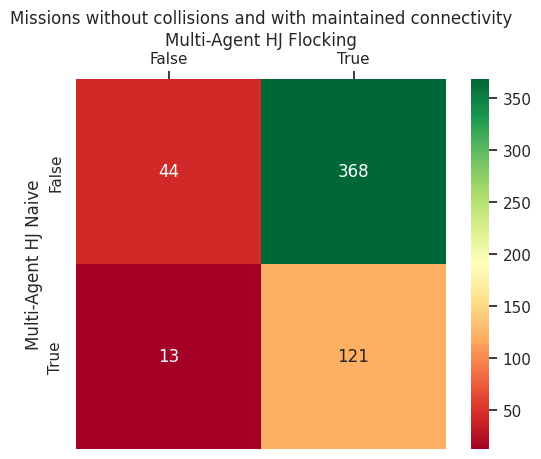

In [19]:
connect_objective_flocking = (metrics_hj_flocking["Isolated_platform_metric"]==0) & (metrics_hj_flocking["Number_of_collision"] == 0)
connect_objective_hj_naive = (metrics_hj_naive["Isolated_platform_metric"]==0) & (metrics_hj_naive["Number_of_collision"] == 0)
plot_confusion_matrix(connect_objective_hj_naive , connect_objective_flocking , 
    'Multi-Agent HJ Naive', 'Multi-Agent HJ Flocking', title_name= 'Missions without collisions and with maintained connectivity')